The goal of this analyis is to study if the altruist agent centrality effect the diffusion of the behaviour or not 

We've done experiments to analyse the diffusion in a barabasi-albert network. First we started with only one central altruistic agent, second experiment is one non central altruistic agent.

## Network Construction 

In [7]:
def NetworkConstruction(N,degree):
    network = []
    G = nx.barabasi_albert_graph(N,degree)
    network = nx.to_dict_of_lists(G) 
    return network,G

## Finding the Central agent

In this section we used three types of centrality measures to define the most central  Degree, K-shell and betweeness

### Degree Centrality 

Niemien Centrality $$\grave{C}_D(p_k) = \frac{\sum_{i=1}^{n}a(p_i,p_k)}{n-1}$$ where $\grave{C}_D(p_k)$ is the relative degree centrality and if there's a link between $p_i$ and $p_k$ then $a(p_i,p_k)$ will be equal to $1$ in the adjacency matrix $A$

In [8]:
def CentralityCalcDegree(G,N):
    cDP = nx.degree_centrality(G)
    agentMaxCentrality = [key for key, value in cDP.items() if value == max(cDP.values())] #i don't need all the max only one
    return cDP,agentMaxCentrality

### Betweeness Centrality

Freeman Centrality

$g_{ij}$ is the geodesics linking between $p_i$ and $p_j$ while $g_{ij}(p_k)$ is the number of geodesics linking between $p_i$ and $p_j$ that contains $p_k$. 

$b_{ij}(pk)$ is the probability that $p_k$ falls on a randomly selected geodesics linking $p_i$ and $p_j$.

Since the probability of choosing anyone of the geodesics will be equal to $$\frac{1}{g_{ij}}$$ then $$b_{ij}(p_k) = \frac{g_{ij}(p_k)}{g_{ij}}$$

To caculate betweenness centrality $C_B(p_k)$ we sum all the probabilities for $p_k$ to fall on every geodesics between $p_i$ and $p_j$ where $i \ne j \ne k$ 

$$C_B(p_k) = \sum_{i<}^{n}\sum_{j}^{n}b_{ij}(p_k)$$

The relative centrality $\grave{C}_B(p_k)$ will be equal to: $$\grave{C}_B(p_k) = \frac{2C_B(p_k)}{n^2-3n+2}$$

In [57]:
def CentralityCalcBetw(G,N):
    cRBp_k = nx.betweenness_centrality(G, k=None, normalized=True, weight=None, endpoints=False, seed=None)
    agentMaxCentrality = [key for key, value in cRBp_k.items() if value == max(cRBp_k .values())] #i don't need all the max only one
    return cRBp_k,agentMaxCentrality

Note: Networkx betweenness centrality is based on Brandes betweenness not freeman (introduced above) which has less complexity instead of $O(n^3)$ it's complexity is $O(nm)$.   

## Finding the non central agent 

Exactly what we've done above except that instead of choosing the max degree will choose the min degree, below is an eample.

In [ ]:
agentMaxCentrality = np.where(cDP == min(cDP))[0][0]

## The Model 

### Initialization

The most central Agent will have a threshold equal to $50$ in order to give it ability to survive till a new mutation take place after $s$ games, which is in our case after $10,000$ game.

In [1]:
def Initialization(N,G):
    #ksc, agentMaxCentrality = CentralityCalcDegree(network,N,G)
    agentsdummy = np.zeros((2,N),dtype=int) #threshold, capital
    agentsdummy[0,:N:1]= 1 
    agents = agentsdummy.T
    #agents[agentMaxCentrality[0]][0] = 50
    return agents

In [2]:
def neighborhood(agent,network): 
    availablePlayers = network[agent]
    return availablePlayers

In [17]:
N = 10
degree = 1
network,G = NetworkConstruction(N,degree)
agents = Initialization(N,G)

In [21]:
agents[2][0]

1

Identify the neighborhood based on the influence not only the connections, so influencial people or those whome i met physically have highr ability to affect me.(it's an idea from the conference)

In [3]:
def ChoosePlayers(agents, N, network): #choose the players, two agents each game like paper 1
    currProposer = randint(1, N-1) 
    availablePlayers = neighborhood(currProposer,network) # who she can play with
    currResponder = choice(availablePlayers)
    return currProposer,currResponder

In [4]:
def TheGame(agents, currProposer, currResponder, M): #capital update following the game rules
    if agents[currProposer][0] >= agents[currResponder][0]: #assuming empathetic agents, where my threshold = proposal amount
        agents[currProposer][1] = agents[currProposer][1] + (M - agents[currProposer][0])
        agents[currResponder][1] = agents[currResponder][1] + agents[currProposer][0]
    return agents

In [5]:
def Selection(agents): 
    agentsdummy = agents.T
    possiblereplicaAgent = np.where(agentsdummy[1] == (max(agentsdummy[1])))
    replicaAgentIndex = choice(possiblereplicaAgent[0])
    possibleremovedAgent = np.where(agentsdummy[1] == (min(agentsdummy[1])))
    removedAgentIndex = choice(possibleremovedAgent[0])
    agents[removedAgentIndex][0] = agents[replicaAgentIndex][0]
    agents[removedAgentIndex][1] = agents[replicaAgentIndex][1]
    return agents, replicaAgentIndex

In [6]:
def Mutation(agents,replicaAgentIndex,M):
    mutationProb = random()
    if mutationProb > 0.666666667  and agents[replicaAgentIndex][0] < M:
        agents[replicaAgentIndex][0]= agents[replicaAgentIndex][0]+1
    if mutationProb < 0.333333333 and agents[replicaAgentIndex][0] > 1:
        agents[replicaAgentIndex][0]= agents[replicaAgentIndex][0]-1
    return agents

In [9]:
def Run(N,M, s, numOfGames,degree):
    clock = 0
    network,G = NetworkConstruction(N,degree)
    agents = Initialization(N,G)
    selfishAgents = N
    #while(selfishAgents >= 1000):
    while(clock <= numOfGames):
        #print selfishAgents
        clock = clock+1
        currProposer,currResponder = ChoosePlayers(agents, N, network)
        agents = TheGame(agents, currProposer, currResponder, M)
        if np.fmod(clock,s) == 0:
            agents,replicaAgentIndex = Selection(agents)
            agents = Mutation(agents,replicaAgentIndex,M)
    averageThreshold = sum(agents.T[0])/N
    return averageThreshold, agents

In [15]:
import networkx as nx 
import numpy as np
from random import *
N = 1000
degree = 10
M = 100
s = 10000
numOfGames =  25000000
i = 0
while i < 5:
    averageThreshold, agents = Run(N, M, s, numOfGames,degree)
    #np.savetxt(("OneCentralAltruist"+str(i)+".csv"), agents, delimiter=",")
    i = i+1

KeyboardInterrupt: 

### Central Vs. None Central Betweeness Centrality 

The analysis here based on one simulation run to show fast results in the paper we conducted 50 simulation runs

#### Average threshold 

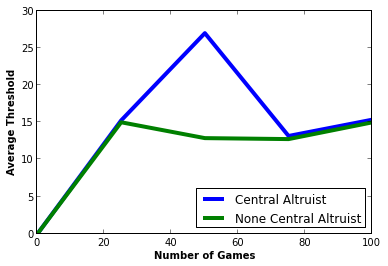

In [1]:
import pylab as plt 
x = [0,25,50,75,100]
betCen = [0,15.24,26.97,13.15,15.34]
betNonCent = [0,14.99,12.86,12.73,14.98] 
plt.plot(x,betCen,linewidth=4)
plt.plot(x,betNonCent,linewidth=4)
plt.ylabel('Average Threshold',fontweight='bold')
plt.xlabel('Number of Games',fontweight='bold')
plt.legend(['Central Altruist','None Central Altruist'], loc='lower right')
plt.show()

#### Number of Selfish Agents

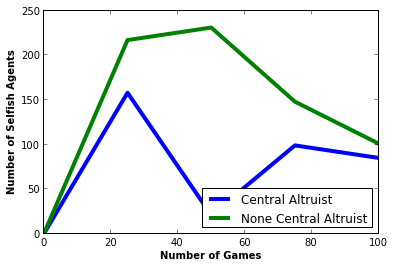

In [2]:
import pylab as plt 
x = [0,25,50,75,100]
betCenSel = [0,158,21,99,85]
betNonCentSel = [0,217,231,148,101] 
plt.plot(x,betCenSel,linewidth=4)
plt.plot(x,betNonCentSel,linewidth=4)
plt.ylabel('Number of Selfish Agents',fontweight='bold')
plt.xlabel('Number of Games',fontweight='bold')
plt.legend(['Central Altruist','None Central Altruist'], loc='lower right')
plt.show()

### Central Vs. None Central Degree Centrality

The analysis here based on one simulation run to show fast results in the paper we conducted 50 simulation runs

#### Average Threshold

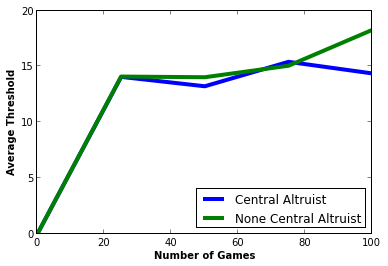

In [53]:
import pylab as plt 
x = [0,25,50,75,100]
degCen = [0,14.06,13.22,15.41,14.37]
degNonCent = [0,14.09,14.03,15.06,18.27] 
plt.plot(x,degCen,linewidth=4)
plt.plot(x,degNonCent,linewidth=4)
plt.ylabel('Average Threshold',fontweight='bold')
plt.xlabel('Number of Games',fontweight='bold')
plt.legend(['Central Altruist','None Central Altruist'], loc='lower right')
plt.show()

#### Number of Selfish Agents

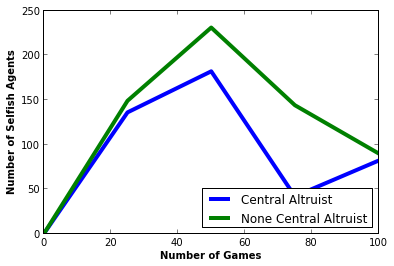

In [54]:
import pylab as plt 
x = [0,25,50,75,100]
degCenSel = [0,136,182,42,82]
degNonCentSel = [0,149,231,144,90] 
plt.plot(x,degCenSel,linewidth=4)
plt.plot(x,degNonCentSel,linewidth=4)
plt.ylabel('Number of Selfish Agents',fontweight='bold')
plt.xlabel('Number of Games',fontweight='bold')
plt.legend(['Central Altruist','None Central Altruist'], loc='lower right')
plt.show()